## Imports

In [1]:
# all the necessary imports to run the file
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys

# installing packages that may not be installed on user's computer
!{sys.executable} -m pip install sounddevice
!{sys.executable} -m pip install librosa
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install keras

import os
import sounddevice as sd
from scipy.io.wavfile import write
import librosa
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import time
import shutil
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') #don't display warnings about librosa falling back onto another package


/opt/anaconda3/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/opt/anaconda3/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
Using TensorFlow backend.


## Initial Data Processing

<pr> The section does NOT need to be run when using the program. It was used to initially load in all the audio files, take 20 mfccs, transform the data, and save the data as numpy arrays for future use. <pr>

In [ ]:
X = list()
y = list()
max_padding = 0

data = Path('.gitignore/tone_perfect_mp3').iterdir()

for item in data:
    if item.is_file():
        filename = item.name.split("_") #"{}{}_{}V{}_MP3.mp3".format(mword, tone, gender, personID)
        y.append(int(filename[0][-1])) 
        
        #transform all of the data to mfccs (Mel Frequency Cepstral Coefficients)
        #https://medium.com/prathena/the-dummys-guide-to-mfcc-aceab2450fd
        
        audio, sampling_rate = librosa.load(item)
        mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=20) 
        X.append(mfcc)
        total_audio_time = len(mfcc[0])
        if total_audio_time > max_padding: max_padding = total_audio_time

#padding each audio file's mcffs with zero so all audio files are considered the same duration 
for i in range(len(X)):
    X[i] = pad_sequences(X[i], padding='post', maxlen = max_padding)

#transforming from (file, coefficients, time) to (file, time, coefficients)
X = np.asarray(X, dtype=np.float32)
X = np.transpose(X, (0, 2, 1))

In [54]:
#save the numpy arrays to significatly cut down on run time 
np.save('mcffs.npy', X)
np.save('labels.npy', y)

# The Model

## Loading in Data

In [7]:
X = np.load('mcffs.npy')
y = np.load('labels.npy')

# Split data into 60% training, 10% testing, and 10% validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = .25)

## Data Visualization

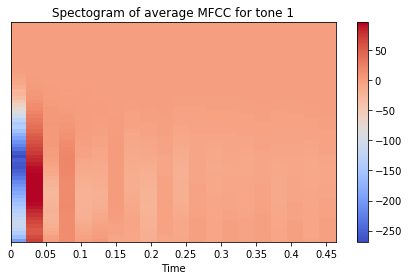

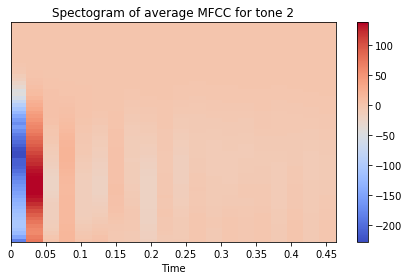

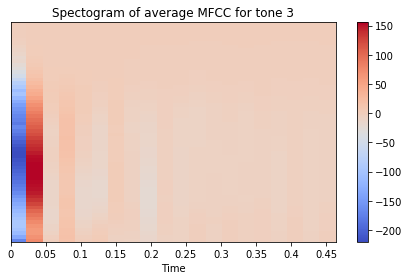

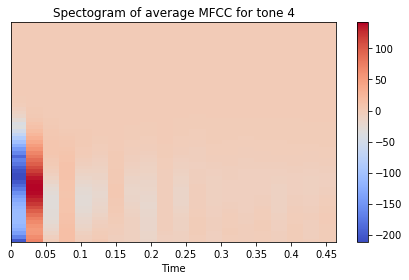

In [92]:
import librosa.display
from itertools import combinations 
  
tones = np.unique(y)

for tone in tones:
    X_tone = X[np.where(y == tone)]
    librosa.display.specshow(np.mean(X_tone, axis=0), x_axis='time')
    plt.colorbar()
    plt.title('Spectogram of average MFCC for tone {}'.format(tone))
    plt.tight_layout()
    plt.show()

# show in a grid plot
# tone_combinations = combinations(tones, 2) 
# for tone1, tone2 in list(tone_combinations): 

In [136]:
# Websites I referred:  
# https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470
# https://adventuresinmachinelearning.com/keras-lstm-tutorial/

from keras.utils import to_categorical
import random

# most of code below was found in the second source above with moderate changes
# since we did not cover RNN or LSTM in class
class KerasBatchGenerator(object):

    def __init__(self, X, y, timesteps, batch_size, num_tones):
        self.X = X
        self.y = to_categorical(y-1, num_classes = num_tones)
        self.timesteps = timesteps
        self.batch_size = batch_size
        self.num_tones = num_tones

    def generate(self):
        # shuffle all the indices so that every epoch's batch sampling is different
        randomized_indices = np.array([*range(0,len(self.X))])
        random.shuffle(randomized_indices)
        
        num_inter = 0
        while True:
            
            start_index = num_inter * self.batch_size
            batch_indices = randomized_indices[start_index: self.batch_size + start_index]
            X_batch = self.X[batch_indices]
            y_batch = self.y[batch_indices]
            
            yield X_batch, y_batch
            
            num_inter += 1
            if len(self.X) <= (num_inter * self.batch_size):
                num_inter = 0
                random.shuffle(randomized_indices)

In [153]:
from keras.models import Sequential 
from keras.layers import LSTM, Dense, TimeDistributed, Activation
from keras.callbacks import ModelCheckpoint


batch_size = 24 
timesteps = len(X_train[0])
hidden_size = 500
num_epochs = 50
tones = 4

X_train_generator = KerasBatchGenerator(X_train, y_train, timesteps, batch_size, tones)                                       
X_validation_generator = KerasBatchGenerator(X_validation, y_validation, timesteps, batch_size, tones)

model = Sequential()
model.add(LSTM(hidden_size, batch_input_shape=(None, timesteps, 20)))
model.add(Dropout(0.5))
model.add(Dense(tones))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

checkpointer = ModelCheckpoint(filepath='model_checkpoints/model-{epoch:02d}.hdf5', verbose=1)
model.fit_generator(X_train_generator.generate(), 
                    len(X_train)//(batch_size*timesteps), 
                    num_epochs, 
                    validation_data = X_validation_generator.generate(), 
                    validation_steps = len(X_validation)//(batch_size*timesteps), 
                    callbacks=[checkpointer])
print(model.summary())

Epoch 1/50
(24, 60, 20)
(24, 4)
(24, 60, 20)(24, 60, 20)
(24, 4)
(24, 60, 20)
(24, 4)

(24, 60, 20)
(24, 4)
(24, 4)
(24, 60, 20)
(24, 4)
(24, 60, 20)
(24, 4)
(24, 60, 20)
(24, 4)
(24, 60, 20)
(24, 4)
(24, 60, 20)(24, 60, 20)
(24, 4)

(24, 4)
(24, 60, 20)
(24, 4)
(24, 60, 20)
(24, 4)
(24, 60, 20)(24, 60, 20)
(24, 4)

(24, 60, 20)
(24, 4)
(24, 4)
(24, 60, 20)
(24, 4)
(24, 60, 20)
(24, 4)
(24, 60, 20)
(24, 4)
(24, 60, 20)
(24, 4)
(24, 60, 20)
(24, 4)
(24, 60, 20)
(24, 4)
(24, 60, 20)
(24, 4)
1/4 [======>.......................] - ETA: 1s - loss: 1.3900 - categorical_accuracy: 0.3750(24, 60, 20)
(24, 4)
2/4 [==============>...............] - ETA: 0s - loss: 1.3423 - categorical_accuracy: 0.2917(24, 60, 20)
(24, 4)
3/4 [=====================>........] - ETA: 0s - loss: 1.3064 - categorical_accuracy: 0.3472(24, 60, 20)
(24, 4)
(24, 60, 20)
(24, 4)
4/4 [==============================] - 1s 343ms/step - loss: 1.2808 - categorical_accuracy: 0.4167 - val_loss: 1.1392 - val_categorical_accuracy: 


Epoch 00013: saving model to model_checkpoints/model-13.hdf5
Epoch 14/50
(24, 60, 20)
(24, 4)
1/4 [======>.......................] - ETA: 0s - loss: 0.9405 - categorical_accuracy: 0.7917(24, 60, 20)
(24, 4)
2/4 [==============>...............] - ETA: 0s - loss: 0.8514 - categorical_accuracy: 0.7083(24, 60, 20)
(24, 4)
3/4 [=====================>........] - ETA: 0s - loss: 0.8545 - categorical_accuracy: 0.6944(24, 60, 20)
(24, 4)
(24, 60, 20)
(24, 4)
4/4 [==============================] - 1s 226ms/step - loss: 0.7855 - categorical_accuracy: 0.7188 - val_loss: 1.0179 - val_categorical_accuracy: 0.5417

Epoch 00014: saving model to model_checkpoints/model-14.hdf5
Epoch 15/50
(24, 60, 20)
(24, 4)
1/4 [======>.......................] - ETA: 0s - loss: 1.0238 - categorical_accuracy: 0.5417(24, 60, 20)
(24, 4)
2/4 [==============>...............] - ETA: 0s - loss: 1.0722 - categorical_accuracy: 0.4583(24, 60, 20)
(24, 4)
3/4 [=====================>........] - ETA: 0s - loss: 1.0663 - categor

2/4 [==============>...............] - ETA: 0s - loss: 0.7280 - categorical_accuracy: 0.6875(24, 60, 20)
(24, 4)
3/4 [=====================>........] - ETA: 0s - loss: 0.6699 - categorical_accuracy: 0.7083(24, 60, 20)
(24, 4)
(24, 60, 20)
(24, 4)
4/4 [==============================] - 1s 211ms/step - loss: 0.6623 - categorical_accuracy: 0.7292 - val_loss: 0.7449 - val_categorical_accuracy: 0.6667

Epoch 00027: saving model to model_checkpoints/model-27.hdf5
Epoch 28/50
(24, 60, 20)
(24, 4)
1/4 [======>.......................] - ETA: 0s - loss: 0.5604 - categorical_accuracy: 0.8333(24, 60, 20)
(24, 4)
2/4 [==============>...............] - ETA: 0s - loss: 0.6287 - categorical_accuracy: 0.7917(24, 60, 20)
(24, 4)
3/4 [=====================>........] - ETA: 0s - loss: 0.5334 - categorical_accuracy: 0.8194(24, 60, 20)
(24, 4)
(24, 60, 20)
(24, 4)
4/4 [==============================] - 1s 211ms/step - loss: 0.5711 - categorical_accuracy: 0.8021 - val_loss: 0.6432 - val_categorical_accuracy:


Epoch 00040: saving model to model_checkpoints/model-40.hdf5
Epoch 41/50
(24, 60, 20)
(24, 4)
1/4 [======>.......................] - ETA: 0s - loss: 0.6837 - categorical_accuracy: 0.6667(24, 60, 20)
(24, 4)
2/4 [==============>...............] - ETA: 0s - loss: 0.6238 - categorical_accuracy: 0.6458(24, 60, 20)
(24, 4)
3/4 [=====================>........] - ETA: 0s - loss: 0.7448 - categorical_accuracy: 0.6111(24, 60, 20)
(24, 4)
(24, 60, 20)
(24, 4)
4/4 [==============================] - 1s 273ms/step - loss: 0.7444 - categorical_accuracy: 0.6354 - val_loss: 0.4841 - val_categorical_accuracy: 0.8333

Epoch 00041: saving model to model_checkpoints/model-41.hdf5
Epoch 42/50
(24, 60, 20)
(24, 4)
1/4 [======>.......................] - ETA: 0s - loss: 0.4913 - categorical_accuracy: 0.8750(24, 60, 20)
(24, 4)
2/4 [==============>...............] - ETA: 0s - loss: 0.5666 - categorical_accuracy: 0.8542(24, 60, 20)
(24, 4)
3/4 [=====================>........] - ETA: 0s - loss: 0.5556 - categor

In [156]:
# plot the training accuracy over time for the chosen hyperparameters
# https://www.codesofinterest.com/2017/03/graph-model-training-history-keras.html


prediction = model.predict(X_test)
accuracy = np.sum(np.argmax(prediction, axis = 1) == y_test - 1)/len(y_test)
print(accuracy)

0.7576219512195121


# User Interface

## Create folder to hold user audio
<p> Run the following cell to remove previous user audio and make the folder to hold all user input audio. <p>

In [ ]:
#initializing folder to hold user audio
user_audio_directory = ("user_audio")
try:
    shutil.rmtree(user_audio_directory)
    os.makedirs(user_audio_directory)
    print("Removed data and recreated folder", user_audio_directory)
except(FileNotFoundError):
    os.makedirs(user_audio_directory)
    print("Created folder {}".format(user_audio_directory)) 

## Record user's voice

<pr> Following cell records a user's voice. Users are encouraged to only record monosyllabic words in order to practice tonalities. An unclear recording will result in a low<pr>

In [ ]:
frame_rate = 44100
duration = 1.5 #seconds

print("Recording in...")
pause = 3

while pause > 0:
    print("{}".format(pause))
    pause -= 1
    time.sleep(1)
print("RECORDING")

recording = sd.rec(int(duration * frame_rate), samplerate = frame_rate, channels = 1)
recording_num = len(os.listdir('user_audio/')) + 1
recording_name = 'user_audio/sample_audio_{}.mp3'.format(recording_num)
sd.wait()
write(recording_name, frame_rate, recording)

print("Finished")

## Play back and plot the user recording 
<pr> User can play back and see a visualization of their latest recording as many times as they like. <pr>

In [ ]:
try: 
    audio, sampling_rate = librosa.load(recording_name)
    
    #plot
    timeline = np.arange(0, len(audio))/sampling_rate
    fig = plt.figure()
    plt.plot(timeline, audio)
    plt.xlabel("Time (s)", fontsize=18)
    plt.ylabel("Amplitude", fontsize=16)
               
    #play back
    sd.play(audio, sampling_rate)
    sd.wait()
    sd.stop()
except(FileNotFoundError):
    print("Please go back and run the previous two cells")


## Delete all user recordings

In [ ]:
try:
    shutil.rmtree(user_audio_directory)
    print("Successfully removed user data")
except(FileNotFoundError):
    print("User data already deleted".format(user_audio_directory)) 

# Classify user recording

In [ ]:
#pad user recording
#make an mcff
#